## Benchmarking


I'm using this code to benchmark underlying function and my code generation tactics

will use a 2B1T + FWTD model and relise it at 20 m/s & 5 deg aoa

In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
from scipy.linalg import eig
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef
import FwtModels.RectWing as rw
import FwtModels.RectWing.Models as rwm

me.mechanics_printing()

### Define the Model

#### Create Parameter instance

In [2]:
test_num = 0
b_modes = 3
t_modes = 3
sm,p = rwm.GenRectWingModel(3,3,fwt_free=False,iwt=True,iwb=True,fwt_frot=True)

In [3]:
p.rho.value = 0.0889
p.s_t.value = 16
p.c.value = 1
p.EI.value = 2e4
p.GJ.value = 1e4
p.rho_t.value = 0.75
p.e_0.value = 0.25
p.e_1.value = 0

In [4]:
#create dict of variations
vars_ls =[]
#vars_ls.append((p.m_factor,[0.5,1,1.5]))
#vars_ls.append((p.Lambda,np.deg2rad([10,17.5,25])))
#vars_ls.append((p.alpha_r,np.deg2rad([0,5,10])))
#vars_ls.append((p.ratio_fwt,[0,0.1,0.2,0.3]))
#vars_ls.append((p.V,np.linspace(0,200,201))) # ensure velocity last so that fixed points iterats up the velocity

vars_ls.append((p.m_factor,[1]))
vars_ls.append((p.Lambda,np.deg2rad([10])))
vars_ls.append((p.alpha_r,np.deg2rad([0,5,10])))
vars_ls.append((p.ratio_fwt,[0,0.1,0.2,0.3]))
vars_ls.append((p.V,np.linspace(0,40,80))) # ensure velocity last so that fixed points iterats up the velocity

In [5]:
flutdfv2 = rw.eigen_perm_params(p,sm,vars_ls,False)

# Setup Numeric Model Parameters


In [7]:
flutdf = flutdfv2.copy()
flutdf['Damping [%]'] = flutdf['Damping']*-100
flutdf['Coast Angle [Deg]'] = flutdf.apply(lambda row: np.rad2deg(row['x'][-2]),axis=1)
flutdf['Flare Angle [Deg]'] = pd.Categorical(np.rad2deg(flutdf['Lambda']))
flutdf['AoA [Deg]'] = pd.Categorical(np.rad2deg(flutdf['alpha_r']))
flutdf['FWT Mass [%]'] = pd.Categorical(flutdf['delta_m']*100)
flutdf['FWT Ratio [%]'] = pd.Categorical(flutdf['sigma']*100)
flutdf['Mode'] = flutdf.Mode.astype('category')

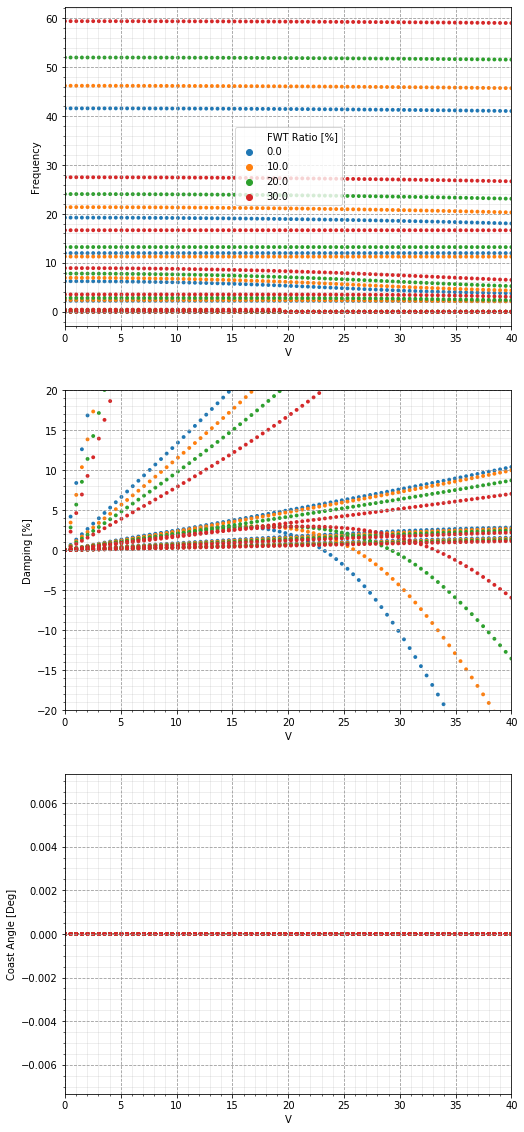

In [8]:
data = flutdf.copy()
data = data[data['Flare Angle [Deg]']==10]
data = data[data['AoA [Deg]']==0]
data = data[data['FWT Mass [%]']==100]
data = data[data['V']<=140]
fig, axes = plt.subplots(3,1,figsize=(8,20))


sns.scatterplot(data=data,x='V',y='Frequency',hue='FWT Ratio [%]',ax=axes[0],edgecolor = 'none',s=15)
sns.scatterplot(data=data,x='V',y='Damping [%]',hue='FWT Ratio [%]',ax=axes[1],legend=False,edgecolor = 'none',s=15)
sns.scatterplot(data=data,x='V',y='Coast Angle [Deg]',hue='FWT Ratio [%]',ax=axes[2],legend=False,edgecolor = 'none',s=15)

for i in [0,1,2]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    axes[i].set(xlim=(0,40))
#axes[0].set(ylim=(0.5,3))
#axes[0].set(ylim=(0,25))
axes[1].set(ylim=(-20,20))

In [10]:
flutdf.to_pickle(f'Test_{test_num}.pkl')

In [11]:
pd.read_pickle(f'Test_{test_num}.pkl').head()

,cn,Real,Imag,Frequency,Damping,Stable,Eigen Vector,Mode,q,delta_m,Lambda,alpha_r,sigma,V,Damping [%],Coast Angle [Deg],Flare Angle [Deg],AoA [Deg],FWT Mass [%],FWT Ratio [%]
0,0.000000+0.000000j,0.000000e+00,0.000000,0.000000,NaN,False,"[0j, 0j, 0j, 0j, 0j, 0j, (1+0j), 0j, 0j, 0j, 0...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1.0,0.174533,0.0,0.0,0.0,NaN,0.0,10.0,0.0,100.0,0.0
1,-0.000000+2.243500j,-2.637582e-15,2.243500,0.357064,-1.048991e-15,False,[(-1.6946790730753291e-12+0.4068796164843542j)...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1.0,0.174533,0.0,0.0,0.0,1.048991e-13,0.0,10.0,0.0,100.0,0.0
2,-0.000000+14.182394j,-5.382995e-12,14.182394,2.257198,-3.794130e-13,False,"[(8.93574514095905e-14-0.06982738577566319j), ...",2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1.0,0.174533,0.0,0.0,0.0,3.794130e-11,0.0,10.0,0.0,100.0,0.0
3,-0.000000+39.272590j,-1.909482e-13,39.272590,6.250427,-4.823749e-15,False,"[0j, 0j, 0j, (6.200829070198793e-12-0.02545426...",3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1.0,0.174533,0.0,0.0,0.0,4.823749e-13,0.0,10.0,0.0,100.0,0.0
4,0.000000+75.362913j,1.876726e-11,75.362913,11.994380,2.491953e-13,False,[(2.818067405401262e-15+0.013052426074595886j)...,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1.0,0.174533,0.0,0.0,0.0,-2.491953e-11,0.0,10.0,0.0,100.0,0.0
